In [1]:
import sys, os

import numpy as np
import SimpleITK as sitk


import matplotlib.pylab as plt

In [2]:
dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/'

In [3]:
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames( dataRoot + '/1/T2SPIR/DICOM_anon' )
reader.SetFileNames(dicom_names)

image = reader.Execute()

size = image.GetSize()

In [4]:
size

(256, 256, 1)

OK! Obviously the dicom files are messed up! The series reader failed to read all files. We have to read them one by one:

In [5]:
import glob

In [15]:
imgList = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/1/T2SPIR/DICOM_anon/*dcm'))):
    imgList.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))

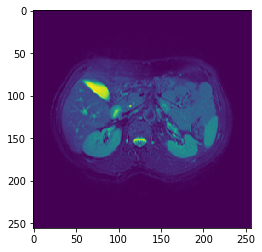

In [16]:
plt.imshow(imgList[20][0,:,:])

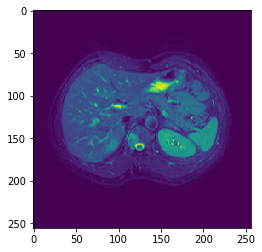

In [17]:
plt.imshow(imgList[25][0,:,:])

In [18]:
IMG = np.zeros((len(imgList),imgList[0].shape[1], imgList[0].shape[2] ))
for cnt,i in enumerate(imgList):
    IMG[cnt,:,:] = i

In [19]:
fixed_image = sitk.GetImageFromArray(IMG)

In [11]:
fixed_image.SetDirection(image.GetDirection())
fixed_image.SetOrigin(image.GetOrigin())
fixed_image.SetSpacing(image.GetSpacing())

OK, now we have our image. We should do the same thing for the label data. It seems the organizers of this challenge were very naive! No one saves medical data in png format! Anyway...

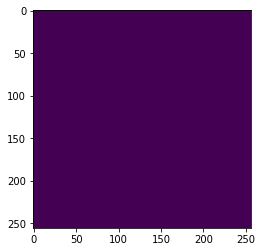

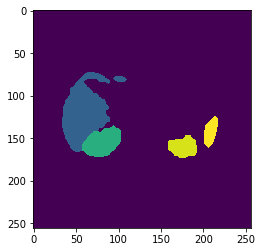

In [12]:
imgList = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/1/T2SPIR/Ground/*png'))):
    #if i<5:
    imgList.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
    
plt.figure()
plt.imshow(imgList[10][:,:])

plt.figure()
plt.imshow(imgList[20][:,:])


    
moving_image= np.zeros((len(imgList),imgList[0].shape[0], imgList[0].shape[1] ))
for cnt,i in enumerate(imgList):
    moving_image[cnt,:,:] = i    
    
    
moving_image= sitk.GetImageFromArray(moving_image)
moving_image.SetDirection(image.GetDirection())
moving_image.SetOrigin(image.GetOrigin())
moving_image.SetSpacing(image.GetSpacing())

Now, let's register T2 image on one of the subjects ...

# Registration

Going to copy and paste in some methods from simpleITK notebook, attempt basic registration.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=10)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [ ]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [ ]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));